# Evaluating custom NER model
Now that I have built a custom NER model and tried it out on some unseen text, I want to compute some evaluation metrics to see exactly how the model performs.

## First need to produce an annotated test set (unseen data)

In [1]:
import json
import random
import pandas as pd
import numpy as np

In [2]:
# Function to load in json file from LightTag
def load_json_to_df(file):
    
    results = json.load(open(file))
    
    # Create list of only those posts which have been annotated
    annotated = []
    for example in results['examples']:
        if example['annotations'] != []:
            annotated.append(example)
            
    return pd.DataFrame(annotated)


# Function to convert data into spacy format
def convert_to_spacy_format(df):
    
    TRAIN_DATA = []
    
    for index, row in df.iterrows():
        
        sentence = row['content']
        annotations_input_list = row['annotations']
        
        annotations_output_list = []
        ing_dict = {}
        
        for annotation in annotations_input_list:
            
            annotations_output_list.append((annotation['start'], annotation['end'], annotation['tag']))
        
        ing_dict['entities'] = annotations_output_list
        TRAIN_DATA.append((sentence, ing_dict))
        
    return TRAIN_DATA

In [3]:
TRAIN_DATA = convert_to_spacy_format(load_json_to_df('ingredient-tagger_annotations.json'))

In [5]:
TEST_DATA = convert_to_spacy_format(load_json_to_df('ingredient-tagger_annotations_2.json'))

In [7]:
test_set = []
for post, entities in TEST_DATA:
    if post not in [TRAIN_DATA[i][0] for i in range(len(TRAIN_DATA))]:
        test_set.append((post, entities))

In [8]:
len(test_set)

14

In [9]:
# Converting test_set to docbin spacy file

import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

def convert_to_spacy_docbin(dataset, file_location):
    
    nlp = spacy.blank("en") # load a new spacy model
    db = DocBin() # create a DocBin object

    for text, annot in tqdm(dataset):
        doc = nlp.make_doc(text) 
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print(f"Skipping entity: {(start,end,label)}")
            else:
                ents.append(span)
        print(ents)
        try:
            doc.ents = ents
        except:
            print(f"Error with document")
        db.add(doc)

    db.to_disk(file_location) # save the docbin object


convert_to_spacy_docbin(test_set, "./test.spacy")

 50%|██████████████████████                      | 7/14 [00:00<00:00, 57.97it/s]

Skipping entity: (136, 143, 'INGREDIENT')
Skipping entity: (103, 109, 'INGREDIENT')
Skipping entity: (122, 126, 'INGREDIENT')
Skipping entity: (70, 71, 'QUANTITY')
Skipping entity: (128, 134, 'INGREDIENT')
Skipping entity: (82, 83, 'QUANTITY')
[2, 45, ham, potatoes, 5, oil, potato, 1]
[red onion, cup, tomatoes, 1, 1 /2, 2, cup, grape, honey, lime juice, cup, 1/4, 1/2, black pepper, basil, 1, watermelon, 5, 1, tb, cup]
[basil, olive oil, basil, pasta, mozzarella, pasta, vinegar, chicken, tomatoes, sausage]
[cream, dash, water, cup, 1/2, 1, 1, chia seeds, 3, vanilla protein powder, cup, oats, vanilla, egg white, teaspoon, egg, 1, 5, banana, 1/2, tablespoon, 1]
Error with document
[ml, 1, 2, 2, 70, 10, 4, flour, 3, eggs, self-raising flour, 5, cup, cup, cup, oranges, teaspoon, 2, 6, sugar, 4, oil, eggs, baking powder, orange juice, 2, oil, cup, sugar, 1, 1, half, sugar, cup, orange juice, half, baking powder, 8, 1, flour]
Error with document
Skipping entity: (307, 309, 'QUANTITY')
[cream 

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 50.43it/s]


[salt, oil, tablespoon, cumin, garam masala, garlic, 2, cup, spices, gram, ghee, cream, teaspoon, 50, paneer, 2, gram, cumin, mawa, pepper, ghee, cinnamon, tablespoon, 15, onion, milk, garlic, 1, cashews, 1, paneer, garam masala, cardamom, 4, cinnamon, yogurt, 1/2, salt, yogurt, oil, cashews, cream, milk, 1, 250, clove, tablespoon, 100, milk, 4, 1, clove, 1, 4, 3, 2, cinnamon, water, 1, teaspoon, 1/2, cup, 8, 1, 5, 3, gram, clove, 2, onion, 2, tej patta, 1, paneer]
[200, snickers, cream, almond butter, gram, cacao, gram, flour, gram, tofu, zucchini, blackberries, gram, 200, chia seeds, banana]
[baking soda, baking powder, 1, 1/2, coconut oil, 1/2, pistachio, vanilla extract, 3, 1/4, 1/2, 1/4, cup, cup, teaspoon, almond, tablespoon, salt, eggs, 1/2, cup, coffee, oil, teaspoon, 1, 1/2, 1/4, 2, 1, 1, chocolate chips, cup, teaspoon, 3, sugar, pistachio, 1, 1, flour, 1/4, 1/2, 1, cup, cinnamon, 1, teaspoon, oil, 30, 1/2, 1/2, cup, almond, teaspoon, 2, 10]
Error with document
[black pepper, 

## Now time to evaluate the model

In [10]:
! python -m spacy evaluate ./model-best ./test.spacy --output ./evaluation_metrics.json

ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   85.21 
NER R   77.07 
NER F   80.94 
SPEED   15811 


=============================== NER (per type) ===============================

                  P       R       F
INGREDIENT    78.85   68.72   73.43
QUANTITY      92.94   85.87   89.27
MEASUREMENT   93.02   93.02   93.02

✔ Saved results to evaluation_metrics.json


In [11]:
json.load(open("evaluation_metrics.json"))

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'ents_p': 0.8521126761,
 'ents_r': 0.7707006369,
 'ents_f': 0.8093645485,
 'ents_per_type': {'INGREDIENT': {'p': 0.7884615385,
   'r': 0.687150838,
   'f': 0.7343283582},
  'QUANTITY': {'p': 0.9294117647, 'r': 0.8586956522, 'f': 0.8926553672},
  'MEASUREMENT': {'p': 0.9302325581, 'r': 0.9302325581, 'f': 0.9302325581}},
 'speed': 15811.3756563589}

# Confusion Matrix
SpaCy does not have an inbuilt function to create a confusion matrix, so instead I shall create one from scratch.

In [12]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

In [13]:
nlp = spacy.load("./model-best")

In [54]:
docs = test_set

In [72]:
len(docs)

14

In [73]:
indexes = [3, 4, 11]
for index in sorted(indexes, reverse=True):
    del docs[index]

In [74]:
len(docs)

11

In [75]:
from spacy.training import offsets_to_biluo_tags
def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label
    
def create_total_target_vector(docs):
    target_vector = []
    for index, doc in enumerate(docs):
        print (doc)
        new = nlp.make_doc(doc[0])
        entities = doc[1]["entities"]
        try:
            bilou_entities = offsets_to_biluo_tags(new, entities)
        except:
            print("\n\n", index, "\nError with document\n\n")
        final = []
        for item in bilou_entities:
            final.append(get_cleaned_label(item))
        target_vector.extend(final)
    return target_vector

In [76]:
def create_prediction_vector(text):
    return [get_cleaned_label(prediction) for prediction in get_all_ner_predictions(text)]

def create_total_prediction_vector(docs: list):
    prediction_vector = []
    for doc in docs:
        prediction_vector.extend(create_prediction_vector(doc[0]))
    return prediction_vector

def get_all_ner_predictions(text):
    doc = nlp(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities

In [77]:
def get_model_labels():
    labels = list(nlp.get_pipe("ner").labels)
    labels.append("O")
    return sorted(labels)
def get_dataset_labels():
    return sorted(set(create_total_target_vector(docs)))

In [78]:
sorted(set(create_total_target_vector(docs)))

('baked potato skins \n\n prep: 5 mins\n cook: 1 hr 45 mins\n\ningredients:\n・5 potatoes\n・3 deli ham, chopped\n・cheese\n・olive oil\n・salt\n・pepper\n・parsley\n\nservings: 2', {'entities': [(155, 156, 'QUANTITY'), (136, 143, 'INGREDIENT'), (103, 109, 'INGREDIENT'), (122, 126, 'INGREDIENT'), (47, 49, 'QUANTITY'), (89, 92, 'INGREDIENT'), (72, 80, 'INGREDIENT'), (28, 29, 'QUANTITY'), (111, 120, 'INGREDIENT'), (6, 12, 'INGREDIENT'), (70, 71, 'QUANTITY'), (42, 43, 'QUANTITY'), (128, 134, 'INGREDIENT'), (82, 83, 'QUANTITY')]})
('savor the end of summer watermelon season with this delicious watermelon salad! this salad is easy to make and deliciously refreshing! \n\nsave this post! full recipe below! \n(for printable recipe card and notes: https://www.chewoutloud.com/watermelon-salad-recipe/) \n\ningredients: \n\n5 cup watermelon, cubed\n1 1 /2 cup yellow grape or cherry tomatoes, halved\n1 small red onion, chopped\n1/2 cup freshly torn basil leaves\n1/4 cup freshly squeezed lime juice\n2 tb p

['', 'INGREDIENT', 'MEASUREMENT', 'O', 'QUANTITY']

In [79]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(docs): 
    classes = sorted(set(create_total_target_vector(docs)))
    y_true = create_total_target_vector(docs)
    y_pred = create_total_prediction_vector(docs)
    print (y_true)
    print (y_pred)
    return confusion_matrix(y_true, y_pred, labels=classes)

In [80]:
generate_confusion_matrix(docs)

('baked potato skins \n\n prep: 5 mins\n cook: 1 hr 45 mins\n\ningredients:\n・5 potatoes\n・3 deli ham, chopped\n・cheese\n・olive oil\n・salt\n・pepper\n・parsley\n\nservings: 2', {'entities': [(155, 156, 'QUANTITY'), (136, 143, 'INGREDIENT'), (103, 109, 'INGREDIENT'), (122, 126, 'INGREDIENT'), (47, 49, 'QUANTITY'), (89, 92, 'INGREDIENT'), (72, 80, 'INGREDIENT'), (28, 29, 'QUANTITY'), (111, 120, 'INGREDIENT'), (6, 12, 'INGREDIENT'), (70, 71, 'QUANTITY'), (42, 43, 'QUANTITY'), (128, 134, 'INGREDIENT'), (82, 83, 'QUANTITY')]})
('savor the end of summer watermelon season with this delicious watermelon salad! this salad is easy to make and deliciously refreshing! \n\nsave this post! full recipe below! \n(for printable recipe card and notes: https://www.chewoutloud.com/watermelon-salad-recipe/) \n\ningredients: \n\n5 cup watermelon, cubed\n1 1 /2 cup yellow grape or cherry tomatoes, halved\n1 small red onion, chopped\n1/2 cup freshly torn basil leaves\n1/4 cup freshly squeezed lime juice\n2 tb p

['O', 'INGREDIENT', 'O', 'O', 'O', 'O', 'QUANTITY', 'O', 'O', 'O', 'O', 'QUANTITY', 'O', 'QUANTITY', 'O', 'O', 'O', 'O', 'O', '', 'INGREDIENT', 'O', '', 'O', 'INGREDIENT', 'O', 'O', 'O', '', 'O', '', '', 'O', '', 'O', '', 'O', '', 'O', 'O', 'O', 'QUANTITY', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'QUANTITY', 'MEASUREMENT', 'INGREDIENT', 'O', 'O', 'O', 'QUANTITY', 'QUANTITY', 'QUANTITY', 'MEASUREMENT', 'O', 'INGREDIENT', 'O', 'O', 'INGREDIENT', 'O', 'O', 'O', 'QUANTITY', 'O', 'INGREDIENT', 'INGREDIENT', 'O', 'O', 'O', 'QUANTITY', 'MEASUREMENT', 'O', 'O', 'INGREDIENT', 'O', 'O', 'QUANTITY', 'MEASUREMENT', 'O', 'O', 'INGREDIENT', 'INGREDIENT', 'O', 'QUANTITY', 'MEASUREMENT', 'O', 'INGREDIENT', 'O', 'O', 'O', 'INGREDIENT', 'INGREDIENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

array([[   0,    4,    0,    9,    1],
       [   0,  150,    0,   55,    0],
       [   0,    1,   40,    2,    0],
       [   0,   16,    3, 1381,    4],
       [   0,    1,    0,   12,   80]])

In [81]:
from matplotlib import pyplot
import numpy

def plot_confusion_matrix(docs, classes, normalize=False, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    title = 'Confusion Matrix, for SpaCy NER'

    # Compute confusion matrix
    cm = generate_confusion_matrix(docs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm, ax, pyplot

('baked potato skins \n\n prep: 5 mins\n cook: 1 hr 45 mins\n\ningredients:\n・5 potatoes\n・3 deli ham, chopped\n・cheese\n・olive oil\n・salt\n・pepper\n・parsley\n\nservings: 2', {'entities': [(155, 156, 'QUANTITY'), (136, 143, 'INGREDIENT'), (103, 109, 'INGREDIENT'), (122, 126, 'INGREDIENT'), (47, 49, 'QUANTITY'), (89, 92, 'INGREDIENT'), (72, 80, 'INGREDIENT'), (28, 29, 'QUANTITY'), (111, 120, 'INGREDIENT'), (6, 12, 'INGREDIENT'), (70, 71, 'QUANTITY'), (42, 43, 'QUANTITY'), (128, 134, 'INGREDIENT'), (82, 83, 'QUANTITY')]})
('savor the end of summer watermelon season with this delicious watermelon salad! this salad is easy to make and deliciously refreshing! \n\nsave this post! full recipe below! \n(for printable recipe card and notes: https://www.chewoutloud.com/watermelon-salad-recipe/) \n\ningredients: \n\n5 cup watermelon, cubed\n1 1 /2 cup yellow grape or cherry tomatoes, halved\n1 small red onion, chopped\n1/2 cup freshly torn basil leaves\n1/4 cup freshly squeezed lime juice\n2 tb p

/Users/maxkirwan/opt/miniconda3/envs/data_analytics/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "baked potato skins 

 prep: 5 mins
 cook: 1 hr 45 ..." with entities "[(155, 156, 'QUANTITY'), (136, 143, 'INGREDIENT'),...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/maxkirwan/opt/miniconda3/envs/data_analytics/lib/python3.9/site-packages/spacy/training/iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "this interesting flavor combo is brought to you by..." with entities "[(70, 82, 'INGREDIENT'), (363, 375, 'INGREDIENT'),...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/Users/maxkirwan/opt/miniconda3/envs/dat

('paneer aaloo mix paratha \n\ningredients: paneer, aaloo, chopped onion and green chilli, black pepper powder, chaat masala, hing, roasted jeera powder, salt, garam masala, red chilli powder, wheat flour and soybean oil.\n\nserve it with butter and achaar, enjoy!\n.\n.\n.\n._.goodness \n.\n.', {'entities': [(87, 99, 'INGREDIENT'), (233, 239, 'INGREDIENT'), (0, 6, 'INGREDIENT'), (40, 46, 'INGREDIENT'), (48, 53, 'INGREDIENT'), (108, 120, 'INGREDIENT'), (150, 154, 'INGREDIENT'), (195, 200, 'INGREDIENT'), (205, 212, 'INGREDIENT'), (136, 148, 'INGREDIENT'), (170, 187, 'INGREDIENT'), (122, 126, 'INGREDIENT'), (63, 68, 'INGREDIENT'), (79, 85, 'INGREDIENT'), (156, 168, 'INGREDIENT'), (244, 250, 'INGREDIENT'), (213, 216, 'INGREDIENT')]})
('egg pakode \n\noh waoo ! now this sounds so interesting \n\negg pakode never thought these little eggs can be eaten like pakodas \n\nif you havent tried it yet, then what are you waiting for \n\nso here we go woo hoo \n\ningredients: \n☆ boiled eggs \n☆ oil 

['O', 'INGREDIENT', 'O', 'O', 'O', 'O', 'QUANTITY', 'O', 'O', 'O', 'O', 'QUANTITY', 'O', 'QUANTITY', 'O', 'O', 'O', 'O', 'O', '', 'INGREDIENT', 'O', '', 'O', 'INGREDIENT', 'O', 'O', 'O', '', 'O', '', '', 'O', '', 'O', '', 'O', '', 'O', 'O', 'O', 'QUANTITY', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'QUANTITY', 'MEASUREMENT', 'INGREDIENT', 'O', 'O', 'O', 'QUANTITY', 'QUANTITY', 'QUANTITY', 'MEASUREMENT', 'O', 'INGREDIENT', 'O', 'O', 'INGREDIENT', 'O', 'O', 'O', 'QUANTITY', 'O', 'INGREDIENT', 'INGREDIENT', 'O', 'O', 'O', 'QUANTITY', 'MEASUREMENT', 'O', 'O', 'INGREDIENT', 'O', 'O', 'QUANTITY', 'MEASUREMENT', 'O', 'O', 'INGREDIENT', 'INGREDIENT', 'O', 'QUANTITY', 'MEASUREMENT', 'O', 'INGREDIENT', 'O', 'O', 'O', 'INGREDIENT', 'INGREDIENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O

(array([[   0,    4,    0,    9,    1],
        [   0,  150,    0,   55,    0],
        [   0,    1,   40,    2,    0],
        [   0,   16,    3, 1381,    4],
        [   0,    1,    0,   12,   80]]),
 <AxesSubplot:title={'center':'Confusion Matrix, for SpaCy NER'}, xlabel='Predicted label', ylabel='True label'>,
 <module 'matplotlib.pyplot' from '/Users/maxkirwan/opt/miniconda3/envs/data_analytics/lib/python3.9/site-packages/matplotlib/pyplot.py'>)

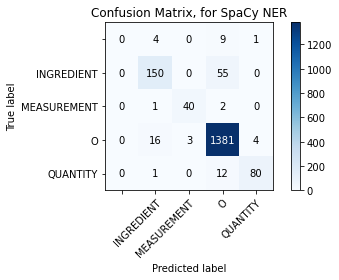

In [82]:
plot_confusion_matrix(docs,classes=get_dataset_labels(),normalize=False)